<a href="https://colab.research.google.com/github/mariyam28-git/Churn-Analysis/blob/main/SentimentAnalyserFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SENTIMENT ANALYSIS**

In [1]:
#Installing required package
!pip install vaderSentiment transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [2]:
# Necessary Imports
# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine learning models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# NLP tools
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
#Importing dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.
Path to dataset files: /kaggle/input/amazon-fine-food-reviews


In [4]:
import pandas as pd

# Path to the CSV file
csv_path = "/kaggle/input/amazon-fine-food-reviews/Reviews.csv"

# Load the dataset safely
df = pd.read_csv(csv_path, encoding='latin1', on_bad_lines='skip')

# Quick check
df.head()
df.shape

(568454, 10)

In [5]:
# Define NLP Tools: stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print("Stopwords and lemmatizer initialized.")


Stopwords and lemmatizer initialized.


In [6]:
#Define Cleaning Function
def clean_text(text):
    text = str(text).lower()                     # lowercase
    text = re.sub(r'[^a-z\s]', '', text)         # remove punctuation and numbers
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

print("Text cleaning function defined.")

Text cleaning function defined.


In [7]:
# Apply cleaning to the dataset
df['Cleaned_Text'] = df['Text'].apply(clean_text)

df[['Text', 'Cleaned_Text']].head()



,Text,Cleaned_Text
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...
2,This is a confection that has been around a fe...,confection around century light pillowy citrus...
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


In [8]:
# Cleaned each review in 'Text' (lowercase, remove punctuation/stopwords, lemmatize) and save to 'Cleaned_Text'


Creating Sentiment Labels

In [9]:
# Function to convert Score to Sentiment labels
def sentiment_label(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply sentiment labeling
df['Sentiment'] = df['Score'].apply(sentiment_label)

# Quick preview
df[['Score', 'Sentiment']].head()


,Score,Sentiment
0,5,positive
1,1,negative
2,4,positive
3,2,negative
4,5,positive


In [10]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,positive


In [11]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Cleaned_Text', 'Sentiment'],
      dtype='object')

In [12]:
# Creating a new DataFrame 'df_model', keeping only the essential columns
df_model = df[['Text', 'Score', 'Cleaned_Text', 'Sentiment']].copy()

# preview
df_model.head()


,Text,Score,Cleaned_Text,Sentiment
0,I have bought several of the Vitality canned d...,5,bought several vitality canned dog food produc...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,1,product arrived labeled jumbo salted peanutsth...,negative
2,This is a confection that has been around a fe...,4,confection around century light pillowy citrus...,positive
3,If you are looking for the secret ingredient i...,2,looking secret ingredient robitussin believe f...,negative
4,Great taffy at a great price. There was a wid...,5,great taffy great price wide assortment yummy ...,positive


EDA


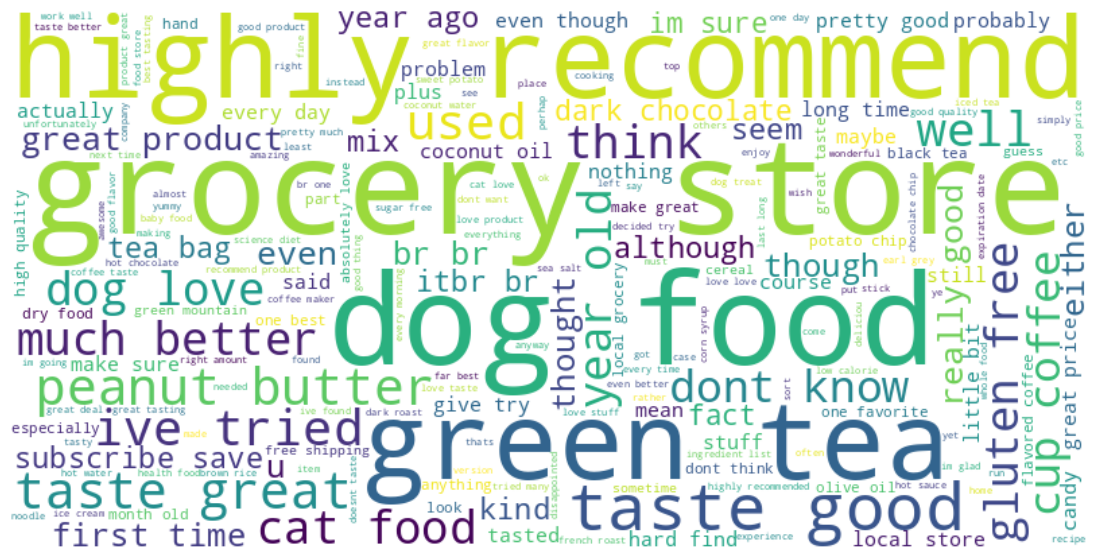

In [13]:
#WORDCLOUD FOR ALL SENTIMENTS
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned reviews
all_text = ' '.join(df_model['Cleaned_Text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


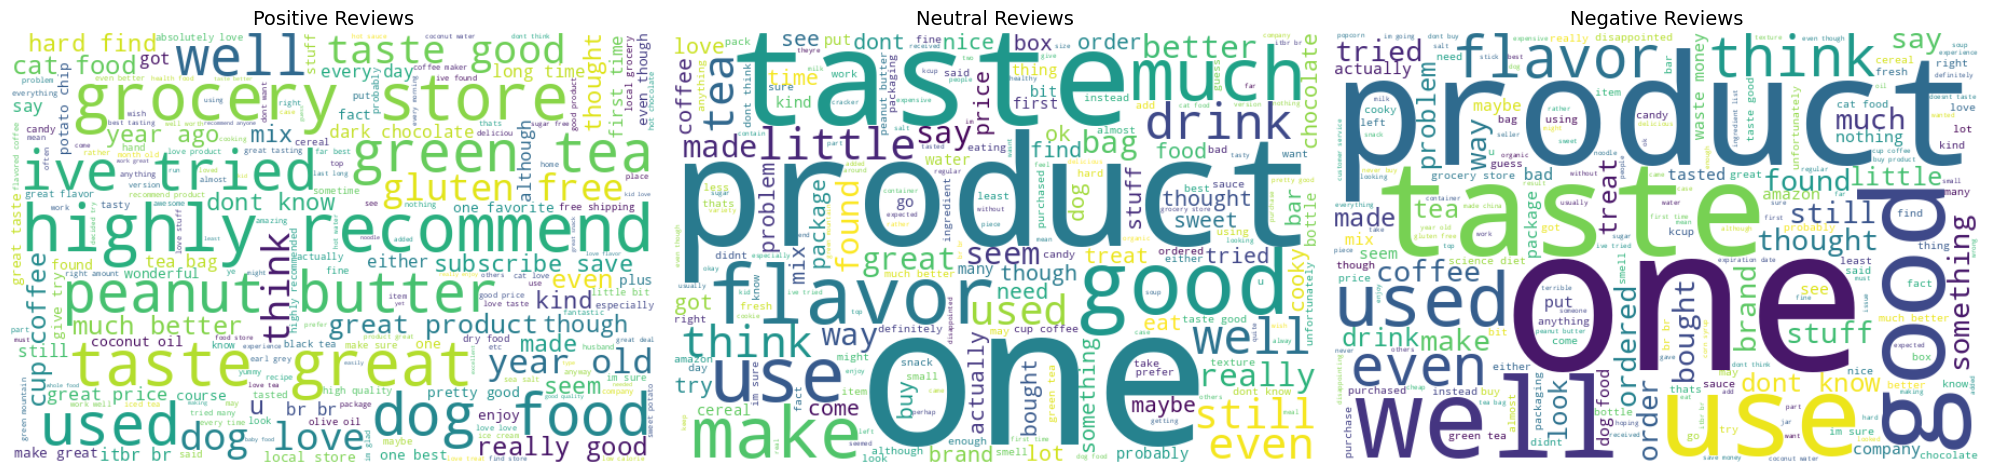

In [14]:
#Wordcloud by sentiment
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sentiments = ['positive', 'neutral', 'negative']

plt.figure(figsize=(20, 6))  # 3 side-by-side plots

for i, sentiment in enumerate(sentiments, 1):
    text = ' '.join(df_model[df_model['Sentiment'] == sentiment]['Cleaned_Text'])
    wc = WordCloud(width=600, height=400, background_color='white').generate(text)

    plt.subplot(1, 3, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.capitalize()} Reviews', fontsize=14)

plt.tight_layout()
plt.show()



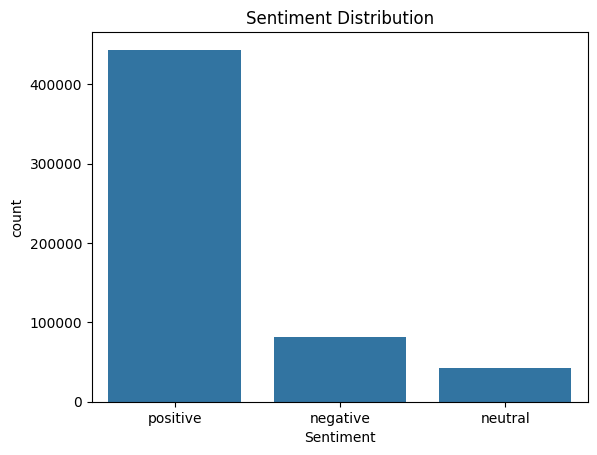

In [15]:
#Sentiment Distribution Plot
import seaborn as sns

sns.countplot(x='Sentiment', data=df_model)
plt.title('Sentiment Distribution')
plt.show()


In [16]:
df_model.shape


(568454, 4)

In [17]:
df_model['Sentiment'].value_counts()


,count
Sentiment,
positive,443777
negative,82037
neutral,42640


In [18]:
#there is strong class imbalance in the dataset which means there are way more positive reviews than neutral or negative reviews.
#Positive:~78%; Negative:~14%; Neutral:~8%

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE


# Train/Test Split

X = df_model['Cleaned_Text']   # features
y = df_model['Sentiment']      # target

# 80/20 split, stratified to keep original distribution in test set
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF Vectorization

vectorizer = TfidfVectorizer(max_features=10000)  # limit features for speed
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)  # use same vectorizer


# Apply SMOTE to Training Set Only

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)


# Summary

print("Original training set shape:", X_train_tfidf.shape, y_train.value_counts())
print("After SMOTE shape:", X_train_res.shape, y_train_res.value_counts())
print("Test set shape (untouched):", X_test_tfidf.shape, y_test.value_counts())


Original training set shape: (454763, 10000) Sentiment
positive    355021
negative     65630
neutral      34112
Name: count, dtype: int64
After SMOTE shape: (1065063, 10000) Sentiment
positive    355021
negative    355021
neutral     355021
Name: count, dtype: int64
Test set shape (untouched): (113691, 10000) Sentiment
positive    88756
negative    16407
neutral      8528
Name: count, dtype: int64


MODEL TRAINING

Logistic Regression Accuracy: 0.8012859417192214

Classification Report:
               precision    recall  f1-score   support

    negative       0.65      0.75      0.70     16407
     neutral       0.29      0.63      0.40      8528
    positive       0.96      0.83      0.89     88756

    accuracy                           0.80    113691
   macro avg       0.63      0.74      0.66    113691
weighted avg       0.87      0.80      0.83    113691



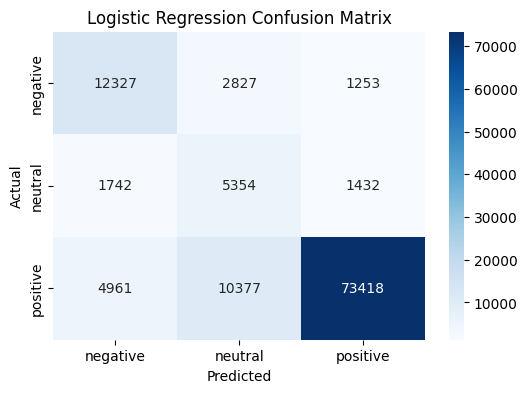

In [20]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=500, random_state=42)

# Train on SMOTE-balanced training set
lr_model.fit(X_train_res, y_train_res)

# Predict on test set
y_pred_lr = lr_model.predict(X_test_tfidf)

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['negative','neutral','positive'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'], cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


SVM (Linear) Accuracy: 0.8461531695560774

Classification Report:
               precision    recall  f1-score   support

    negative       0.69      0.60      0.64     16407
     neutral       0.40      0.16      0.23      8528
    positive       0.88      0.96      0.92     88756

    accuracy                           0.85    113691
   macro avg       0.66      0.57      0.60    113691
weighted avg       0.82      0.85      0.83    113691



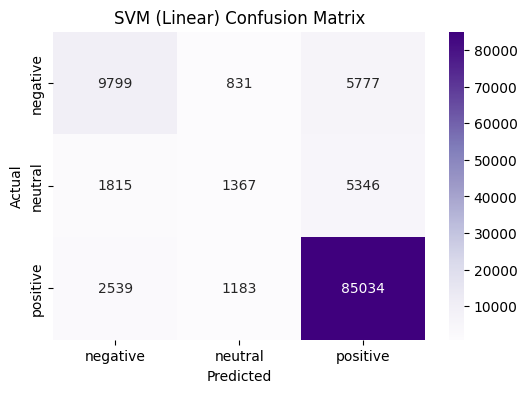

In [21]:
# SVM (Optimized for Large Text Data)
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# SAMPLE SMALLER DATA FOR SPEED
# Taking a subset of training data (e.g., 20k rows max)
X_train_small = X_train_res[:20000]
y_train_small = y_train_res[:20000]

# Initialize Linear SVM (fast for text classification)
svm_model = LinearSVC(random_state=42)

# Train on smaller, balanced data
svm_model.fit(X_train_small, y_train_small)

# Predict on test set
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluation
print("SVM (Linear) Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm, labels=['negative', 'neutral', 'positive'])
cm_df = pd.DataFrame(cm, index=['negative', 'neutral', 'positive'], columns=['negative', 'neutral', 'positive'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("SVM (Linear) Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [22]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

VADER Accuracy: 0.7876612924505898
VADER Classification Report:
               precision    recall  f1-score   support

    negative       0.55      0.29      0.38     16407
     neutral       0.12      0.03      0.05      8528
    positive       0.82      0.95      0.88     88756

    accuracy                           0.79    113691
   macro avg       0.50      0.43      0.44    113691
weighted avg       0.73      0.79      0.75    113691



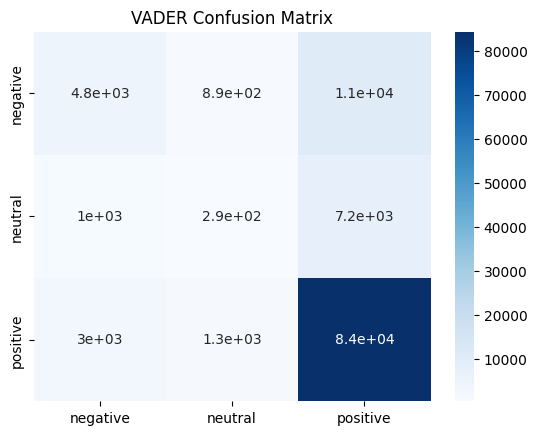

In [23]:
# VADER Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Apply VADER to your text column
vader_preds = []
for review in X_test_text:  # replace X_test_text with your actual test text variable
    score = vader.polarity_scores(review)['compound']
    if score >= 0.05:
        vader_preds.append('positive')
    elif score <= -0.05:
        vader_preds.append('negative')
    else:
        vader_preds.append('neutral')

# Evaluation
print("VADER Accuracy:", accuracy_score(y_test, vader_preds))
print("VADER Classification Report:\n", classification_report(y_test, vader_preds))

# Confusion Matrix
cm_vader = confusion_matrix(y_test, vader_preds, labels=['negative', 'neutral', 'positive'])
sns.heatmap(pd.DataFrame(cm_vader, index=['negative','neutral','positive'],
                         columns=['negative','neutral','positive']), annot=True, cmap='Blues')
plt.title("VADER Confusion Matrix")
plt.show()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


RoBERTa Accuracy: 0.777

RoBERTa Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00       297
     neutral       0.00      0.00      0.00       149
    positive       0.78      1.00      0.87      1554

    accuracy                           0.78      2000
   macro avg       0.26      0.33      0.29      2000
weighted avg       0.60      0.78      0.68      2000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


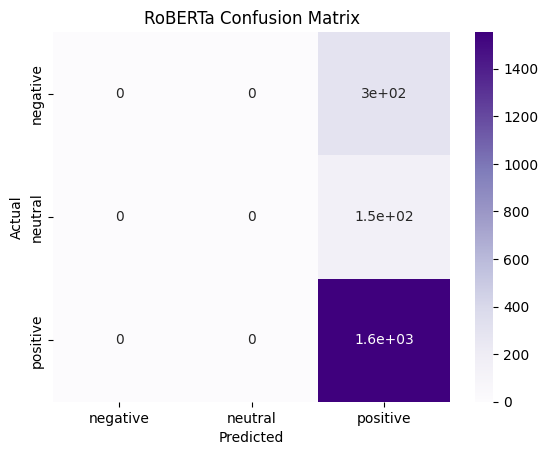

In [24]:
# RoBERTa Sentiment Analysis (robust version)
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize RoBERTa sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Subset of test data for speed
subset_size = 2000
subset_texts = X_test_text[:subset_size].astype(str).tolist()  # ensure list of strings
y_test_subset = y_test[:subset_size]

# Predict one review at a time with truncation
roberta_preds = []
for review in subset_texts:
    result = sentiment_pipeline(review, truncation=True, max_length=512)[0]  # truncate long text
    label = result['label'].lower()
    if 'neg' in label:
        roberta_preds.append('negative')
    elif 'neu' in label:
        roberta_preds.append('neutral')
    else:
        roberta_preds.append('positive')

# Accuracy
print("RoBERTa Accuracy:", accuracy_score(y_test_subset, roberta_preds))

# Classification report
print("\nRoBERTa Classification Report:\n", classification_report(y_test_subset, roberta_preds))

# Confusion Matrix
cm_rob = confusion_matrix(y_test_subset, roberta_preds, labels=['negative', 'neutral', 'positive'])
sns.heatmap(pd.DataFrame(cm_rob, index=['negative','neutral','positive'],
                         columns=['negative','neutral','positive']), annot=True, cmap='Purples')
plt.title("RoBERTa Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 656s 228ms/step - accuracy: 0.8332 - loss: 0.4686 - val_accuracy: 0.8672 - val_loss: 0.3582
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 687s 242ms/step - accuracy: 0.8693 - loss: 0.3505 - val_accuracy: 0.8732 - val_loss: 0.3416
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 653s 230ms/step - accuracy: 0.8789 - loss: 0.3244 - val_accuracy: 0.8774 - val_loss: 0.3362
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 89s 25ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.66      0.72     16407
     neutral       0.51      0.28      0.36      8528
    positive       0.91      0.97      0.94     88756

    accuracy                           0.88    113691
   macro avg       0.73      0.64      0.67    113691
weighted avg       0.86      0.88      0.86    113691



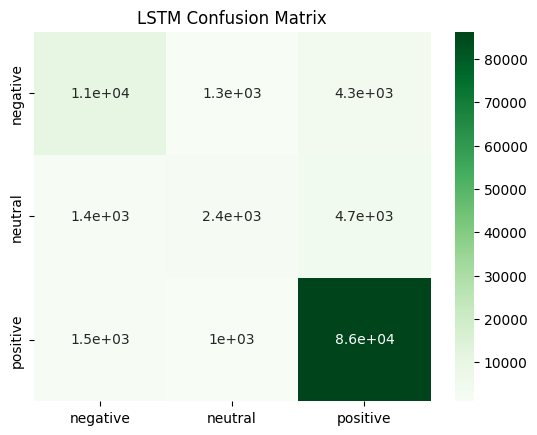

In [25]:
# LSTM Sentiment Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Tokenize text
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=max_len)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Build simple LSTM
model = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_seq, y_train_enc, epochs=3, batch_size=128, validation_split=0.2)

# Predict
y_pred_lstm = model.predict(X_test_seq)
y_pred_lstm = le.inverse_transform(y_pred_lstm.argmax(axis=1))

# Evaluation
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm, labels=['negative', 'neutral', 'positive'])
sns.heatmap(pd.DataFrame(cm_lstm, index=['negative','neutral','positive'],
                         columns=['negative','neutral','positive']), annot=True, cmap='Greens')
plt.title("LSTM Confusion Matrix")
plt.show()


LSTM Accuracy: 0.875302354627895
LSTM Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.66      0.72     16407
     neutral       0.51      0.28      0.36      8528
    positive       0.91      0.97      0.94     88756

    accuracy                           0.88    113691
   macro avg       0.73      0.64      0.67    113691
weighted avg       0.86      0.88      0.86    113691



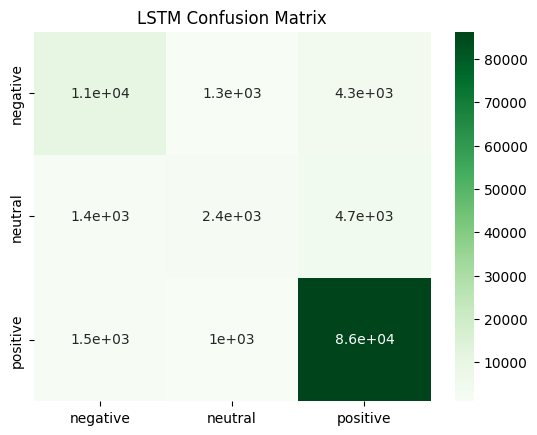

In [26]:
# Accuracy
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))

# Classification Report
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm, labels=['negative', 'neutral', 'positive'])
sns.heatmap(pd.DataFrame(cm_lstm, index=['negative','neutral','positive'],
                         columns=['negative','neutral','positive']), annot=True, cmap='Greens')
plt.title("LSTM Confusion Matrix")
plt.show()